## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [3]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/mmus/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/mmus/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/mmus/'
gtf_name = 'mm10.refGene.gtf'
mutation = 'Fmr1'
samp_num = '1'
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

# Loading up the csv file.

In [5]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

## Determine KS statistic for all transcripts

In [6]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    p_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, transcripts):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
            smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)
            ks = max(abs(cumul_m - cumul_c))
            n = len(tr_m)
            m = len(tr_c)
            en = (n*m)/(n+m)
            p = kstwo.sf(ks,np.round(en))
            ks_list.append(ks)
            p_list.append(p)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            

    # Calculate the -10 log of the P values in order to visualize the smallest values. 
    log_p = []
    for p in p_list:
        if p != 0:
            log_p.append(math.log(p, 0.1))
        else:
            log_p.append(200)
            
    # reorganizing the lists into a dataframe. 
    df = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, p_list, log_p)))
    df.columns = ["gene_ID","transcript_ID", "ks_stat", "p_value", "-10logp"]
    df.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [7]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

Text(0.5, 1.0, 'KS statistic of all mouse transcripts')

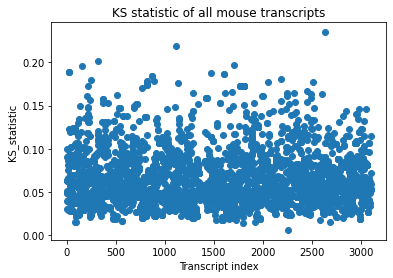

In [8]:
plt.scatter(list(range(len(df["ks_stat"]))), df["ks_stat"])
plt.ylabel("KS_statistic")
plt.xlabel("Transcript index")
plt.title("KS statistic of all mouse transcripts")

Text(0.5, 1.0, '-10log transformed p-values of all KS tests (mouse)')

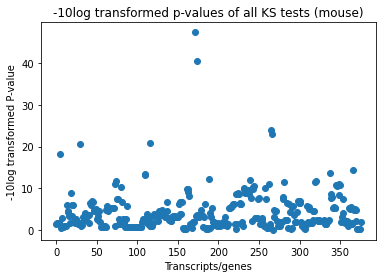

In [119]:
plt.scatter(list(range(len(df["-10logp"]))), df["-10logp"])
plt.ylabel("-10log transformed P-value")
plt.xlabel("Transcripts/genes")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.ylim(0,250)
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

In [10]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets.csv')

In [11]:
# plot the -10log p_values for the Fmr1 targets
df2 = pd.merge(df, Fmr1_targets, how = "inner", left_on="gene_ID", right_on="MOUSE")
plt.scatter(list(range(len(df2['-10logp']))), df2['-10logp'])
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

KeyError: 'MOUSE'

## Observe the count arrays for the genes with the smallest P-value after conducting the KS-test. 

In [37]:
group = df[df['-10logp'] > 30].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['-10logp'].unique())

In [60]:
def big_dif_mmus(diff_dist, transcripts, data_mutant, data_control, figsize = (16,50), fontsize = 12):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, logp, gi in zip(ax, diff_dist, diff_dist.index):
            my_transcript, my_vec_mutant, my_vec_control, index = kat.find_trans_mmus(gi, 
                                           transcripts, data_mutant, data_control)
            maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

            axi[0].plot(my_vec_mutant)
            axi[0].text(len(my_vec_mutant)/20, maxi/1.2, "-10log(p) = " + str(logp), fontsize = fontsize)
            axi[0].set_ylim([0,maxi])
            axi[0].set_ylabel("Read Counts", fontsize = fontsize)
            axi[0].set_xlabel("Codon Position", fontsize = fontsize)
            axi[0].set_title("mutant " + gi, fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi])
            axi[1].set_ylabel("Read Counts", fontsize = fontsize)
            axi[1].set_xlabel("Codon Position", fontsize = fontsize)
            axi[1].set_title("control " + gi, fontsize = fontsize)
    fig.tight_layout()  
    return ax

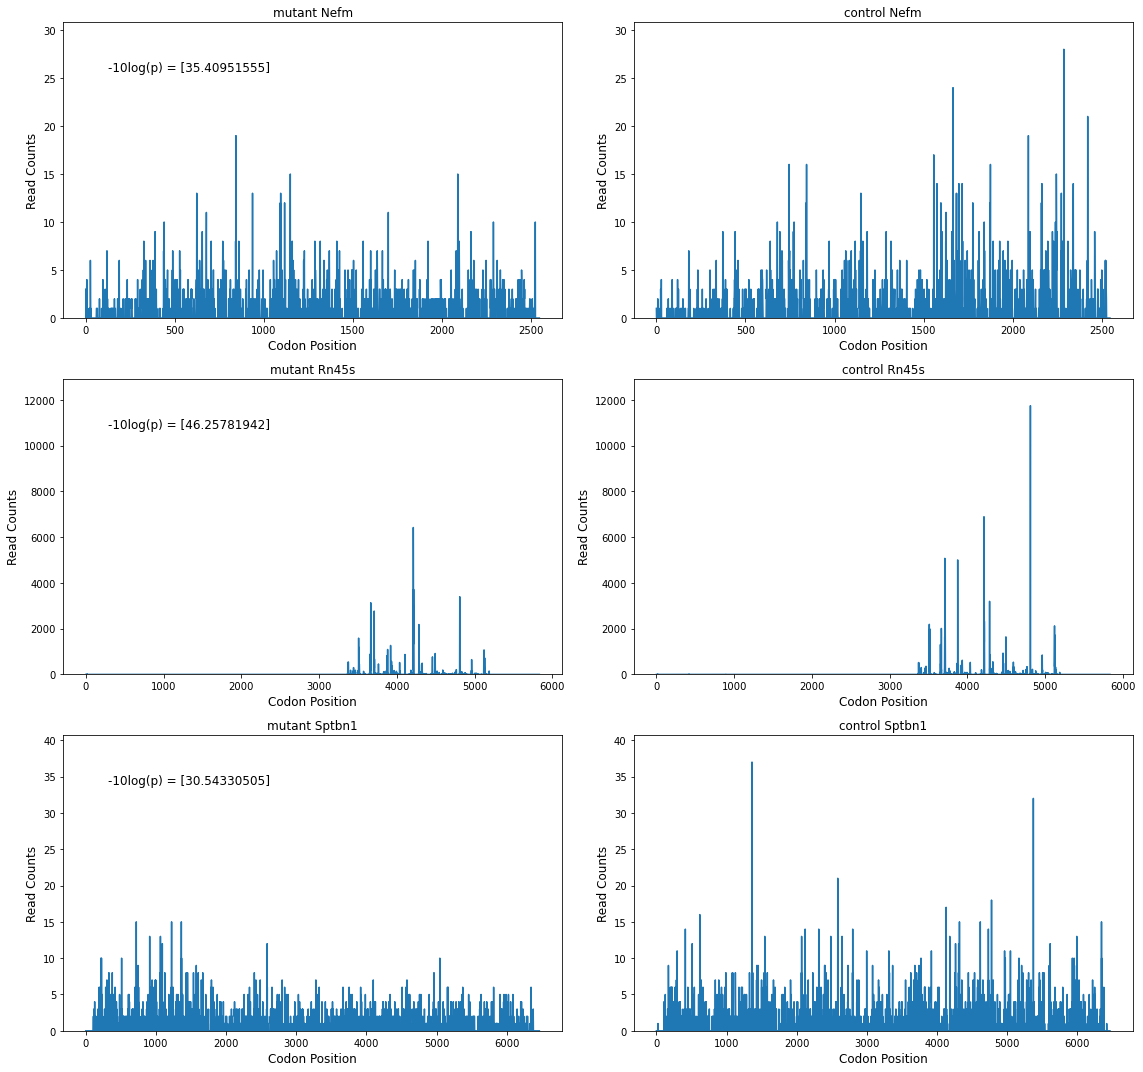

In [61]:
ax = big_dif_mmus(diff_dist, transcripts, data_mutant, data_control, figsize = (16,15), fontsize = 12)

## Choose a gene of interest and observe the smooth and unsmooth array.

In [71]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
gene = 'Nefm'
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_trans_mmus(gene, 
                                           transcripts, data_mutant, data_control)

In [72]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [73]:
sum(my_vec_control)

2818

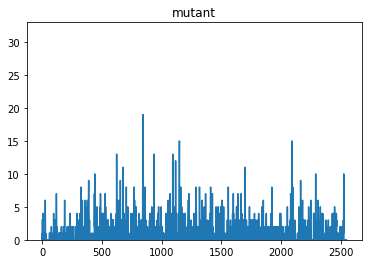

Text(0.5, 1.0, 'control')

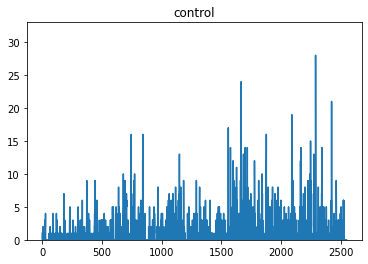

In [74]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.plot(my_vec_mutant)
plt.ylim([0,maxi+5])
plt.title("mutant")
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,maxi+5])
plt.title("control")

When looking at the absolute largest values of P, we find this shape where the reads completely smooth out over time very consistently. 

In [75]:
sum(my_vec_mutant)

2373

In [76]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_position, my_vec_control+0.00000000001)

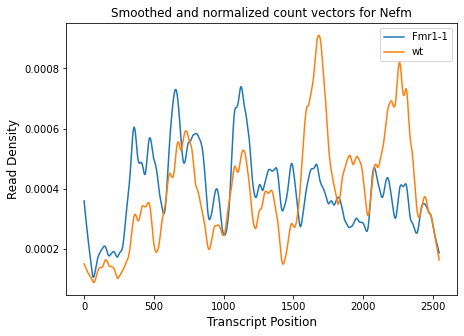

In [81]:
plt.figure(figsize = (7,5))
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density", fontsize = 12)
plt.xlabel("Transcript Position", fontsize = 12)
plt.title("Smoothed and normalized count vectors for " + gene)
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

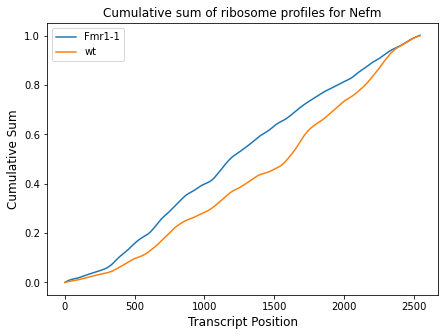

In [83]:
plt.figure(figsize = (7,5))
plt.plot(my_position, cumul_m, label = "Fmr1-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum", fontsize = 12)
plt.xlabel("Transcript Position", fontsize = 12)
plt.title("Cumulative sum of ribosome profiles for " + gene)
plt.legend()

In [70]:
stats.ks_2samp(my_vec_mutant/sum(my_vec_mutant), my_vec_control/sum(my_vec_control))

KstestResult(statistic=0.17864153906556735, pvalue=6.570484549817271e-36)

In [ ]:
stats.pearsonr(cumul_m,cumul_c)

Wait a second, if I am using the cumulative sum for these KS-tests than wouldn't the P-values scale up with the length of the transcript since the function is going to take the number of inputs as the number of independent samples? like, if it sees a bunch of zeroes it is going to think that we actually ran a test and got a bunch of zeroes wont it? and this would apply to the normal data too. 

Figure out a threshold for the P-values from the mass spec data in the E-coli paper. And also put all P values on same scale. Create a formal figure that is showing all of this in a succinct and well explained way. 

In [86]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets/Fmr1_mmus_downreg_genes.txt',
                          names = ["gene_name"])

In [87]:
Fmr1_targets["gene_name_lower"] = Fmr1_targets["gene_name"].str.lower()

In [115]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == True:
    ks_list = []
    p_list = []
    gene_list = []
    x=0
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, transcripts):
        if transcript.attr["gene_name"].lower() in list(Fmr1_targets["gene_name_lower"]):
            x=x+1
            if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.1 and sum(tr_c)/len(tr_c) > 0.1:
                position = np.array(list(range(len(tr_m))))
                smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
                smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)
                ks = max(abs(cumul_m - cumul_c))
                n = len(tr_m)
                m = len(tr_c)
                en = (n*m)/(n+m)
                p = kstwo.sf(ks,np.round(en))
                ks_list.append(ks)
                p_list.append(p)
                gene_list.append(transcript.attr["gene_name"])
                tr_id.append(transcript.get_name())
            

    # Calculate the -10 log of the P values in order to visualize the smallest values. 
    log_p = []
    for p in p_list:
        if p != 0:
            log_p.append(math.log(p, 0.1))
        else:
            log_p.append(200)
            
    # reorganizing the lists into a dataframe. 
    df = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, p_list, log_p)))
    df.columns = ["gene_ID","transcript_ID", "ks_stat", "p_value", "-10logp"]
    #df.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

62/300, no good.

In [118]:
x

688

In [117]:
len(df["gene_ID"].unique())

145

In [107]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets/Fmr1_mmus_downreg_genes.txt',
                          names = ["gene_name"])

In [108]:
g_list = []
for transcript in transcripts:
    g_list.append(transcript.attr["gene_name"])

Looks like we are only looking at the mouse genes with protein sequence data, double check that this is intentional? 

In [109]:
len(pd.DataFrame(g_list)[0].unique())

25239

In [110]:
dfg = pd.DataFrame({"gene_name" : g_list})

In [111]:
dfg["gene_name_lower"] = dfg["gene_name"].str.lower()

In [112]:
Fmr1_targets["gene_name_lower"] = Fmr1_targets["gene_name"].str.lower()

In [113]:
df2 = pd.merge(Fmr1_targets, dfg, how = "inner", on="gene_name_lower")

In [114]:
len(df2.gene_name_lower.unique())

312